<h1> Capstone Project - The Battle of Neighborhoods (Week 2) </h1>

<h2> Download necessary libraries </h2>

In [1]:

#!conda install -c anaconda lxml --yes
#!conda install -c anaconda xlrd --yes
#!pip install BeautifulSoup4
#!pip install requests
#!pip install wget
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes 
#!pip install geocoder

<h2> Make all necessary Imports </h2>

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Imports completed')

Imports completed


<h2> Get Toronto Data </h2>

In [3]:
path  = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(path)

df = pd.read_html(path, header=0, na_values = ['Not assigned'])[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


<h2> Cleanup Data </h2>

In [4]:
#Drop NaN records
df.dropna(subset=['Borough'], inplace=True)

#Replace empty Neighborhood with Borough Data
df['Neighborhood'].fillna(df['Borough'], inplace=True)
empty_hood = df[df['Neighborhood'].isna()].shape[0]
print('Check Empty Neighborhood Records: {}'.format(empty_hood))
#df.head(10)
print('Data size is:',df.shape)

#Separate Neighborhoods using comma & group by Postal Codes, then Borough
toronto_df =pd.DataFrame( df.groupby(['Postal Code','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)]))
toronto_df.reset_index(inplace=True)
toronto_df.head(10)




Check Empty Neighborhood Records: 0
Data size is: (103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


<h2> Get Geo Data </h2>

In [5]:
geo_path = 'http://cocl.us/Geospatial_data'
df_coord = pd.read_csv(geo_path)
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<h2> Merge Postal Codes Dataframe with Latituge/Longitude Data </h2>

In [6]:
toronto_hoods = pd.merge(toronto_df, df_coord, on='Postal Code')
toronto_hoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2> Plot the Map of Toronto with the Neighborhoods </h2>

In [32]:
# create map of Toronto using first entries latitude and longitude values
map_toronto = folium.Map(location=[toronto_hoods["Latitude"][0], toronto_hoods["Longitude"][0]], zoom_start=10)

# add Borough abd Neighborhood markers to map
for lat, lng, borough, neighborhood in zip(toronto_hoods['Latitude'], toronto_hoods['Longitude'], toronto_hoods['Borough'], toronto_hoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h2> For Displaying on GitHub </h2>

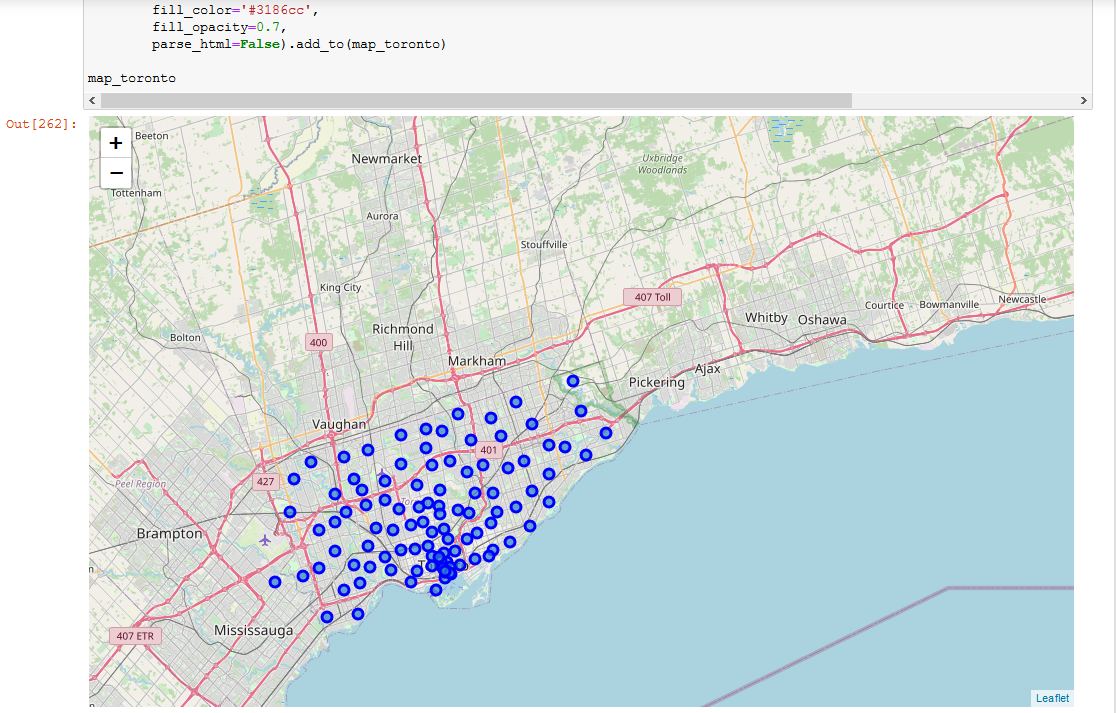

In [8]:
from IPython.display import Image
Image(filename='final_1.png') 

<h2> Setup FourSquare Credentials </h2>

In [9]:
CLIENT_ID = 'LFMNUAIN0PBILSX2JQKVCXNHDOQWCHJC20ENRWTD2OL5O2SG' # your Foursquare ID
CLIENT_SECRET = 'CELNFYGFD5CHN00KU5JRDGSIYBJQH025FA5B0SL3QQW4DNVT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

<h2> Function for getting nearby Venues </h2>

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h2> Retreive and Store Venues </h2>

In [11]:
toronto_venues = getNearbyVenues(names=toronto_hoods['Neighborhood'],latitudes=toronto_hoods['Latitude'],longitudes=toronto_hoods['Longitude'])
print('size of venues dataset :  ',toronto_venues.shape)
toronto_venues.head()


size of venues dataset :   (2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


<h2> Onehot Encoding of Venues</h2>

In [12]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[cols]

toronto_onehot = toronto_onehot.groupby('Neighborhood').mean().reset_index()

print(toronto_onehot.shape)
toronto_onehot.head()

(95, 272)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0

<h2> Get or Venue of Interest (Coffee Shops) to perform Clustering </h2>

In [13]:
coffee_shops = toronto_onehot[["Neighborhood","Coffee Shop"]]
print(coffee_shops.shape)
coffee_shops.head()

(95, 2)


,Neighborhood,Coffee Shop
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.125000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.100000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.086957


<h2> Find the best value for K </h2>

In [42]:
venue_clustering= coffee_shops.drop('Neighborhood', 1)

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(venue_clustering)
    label = kmeans.labels_
    sil_score = silhouette_score(venue_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_score))

For n_clusters=2, The Silhouette Coefficient is 0.8832719607867642
For n_clusters=3, The Silhouette Coefficient is 0.7239484158458013
For n_clusters=4, The Silhouette Coefficient is 0.7898104190488084
For n_clusters=5, The Silhouette Coefficient is 0.7857912460806503
For n_clusters=6, The Silhouette Coefficient is 0.7915164153882965
For n_clusters=7, The Silhouette Coefficient is 0.7807609689382518
For n_clusters=8, The Silhouette Coefficient is 0.7970526080262189
For n_clusters=9, The Silhouette Coefficient is 0.800485923251881


<h2> Perform K Means Clustering </h2>

In [22]:
# k=9 has the highest silhoutte coeff
kclusters = 9
toronto_clustered = coffee_shops.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1)
kmeans.fit_transform(toronto_clustered)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:20]

# copy dataset add clustering labels
toronto_coffee = coffee_shops.copy()
toronto_coffee["Cluster Labels"] = kmeans.labels_

print(toronto_coffee.shape)
toronto_coffee.head()

(95, 3)


,Neighborhood,Coffee Shop,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.125000,1
2,"Bathurst Manor, Wilson Heights, Downsview North",0.100000,7
3,Bayview Village,0.000000,0
4,"Bedford Park, Lawrence Manor East",0.086957,7


<h2> Merge the Location Data with the Clustered Data </h2>

In [23]:
#merge the dataframes

toronto_merged=pd.merge(toronto_coffee.set_index('Neighborhood'),toronto_venues, on='Neighborhood')
#toronto_merged.drop(toronto_merged[toronto_merged['Venue Category'] != "Coffee Shop"].index, inplace=True)

print(toronto_merged.shape)
toronto_merged.head()

(2130, 9)


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
1,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
2,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
3,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
4,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


<h2> Plot the Map of the Clustered Data for Coffee Shops </h2>

In [44]:
lat = 43.651070
long = -79.347015
map_clusters = folium.Map(location=[lat, long],zoom_start=14)

# add colors to identify clusters 
markers_colors={}
markers_colors[0] = 'yellow'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'orange'
markers_colors[4] = 'purple'
markers_colors[5] = 'black'
markers_colors[6] = 'cyan'
markers_colors[7] = 'red'
markers_colors[8] = 'magenta'

# add markers to the map
for lat, lon, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color =markers_colors[cluster],
        fill = True,
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2> For Displaying Cluster Plot/Map on GitHub  </h2>

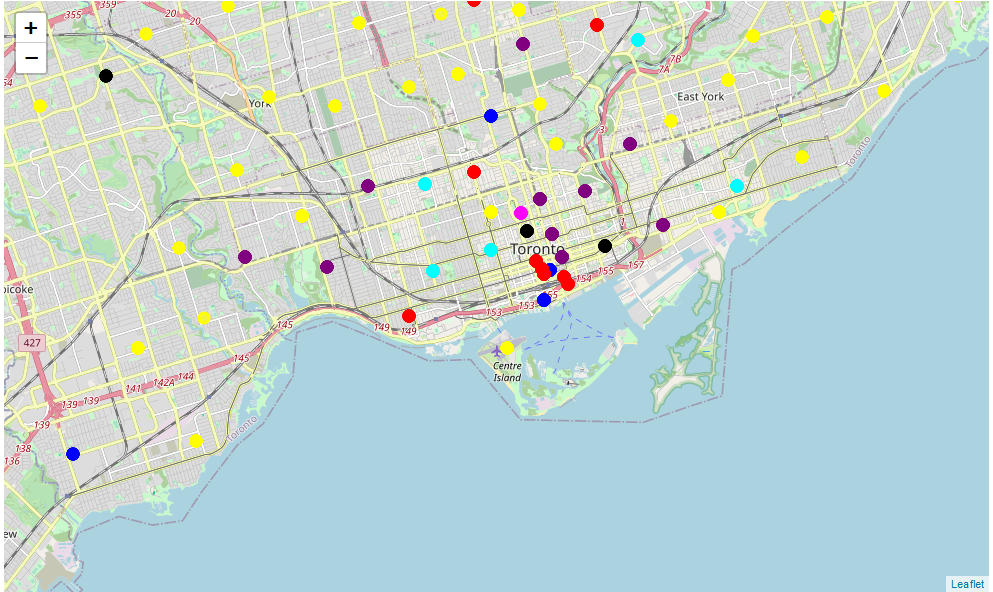

In [45]:
from IPython.display import Image
Image(filename='final_2.png') 

<h2> Lets see how many coffee shops each cluster has </h2>

In [31]:
print('Cluster 0 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==0) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 1 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==1) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 2 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==2) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 3 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==3) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 4 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==4) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 5 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==5) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 6 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==6) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 7 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==7) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)
print('Cluster 8 shape : ',toronto_merged.loc[(toronto_merged['Cluster Labels'] ==8) & (toronto_merged['Venue Category'] == 'Coffee Shop')].shape)


Cluster 0 shape :  (0, 9)
Cluster 1 shape :  (29, 9)
Cluster 2 shape :  (2, 9)
Cluster 3 shape :  (3, 9)
Cluster 4 shape :  (43, 9)
Cluster 5 shape :  (22, 9)
Cluster 6 shape :  (10, 9)
Cluster 7 shape :  (57, 9)
Cluster 8 shape :  (8, 9)


<h2> Lets view cluster 7 as it has the most coffeee shops </h2>

In [34]:
cluster7=toronto_merged.loc[(toronto_merged['Cluster Labels'] ==7) & (toronto_merged['Venue Category'] == 'Coffee Shop')]
#cluster0.groupby('Neighborhood').sum()
cluster7


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
17,"Bathurst Manor, Wilson Heights, Downsview North",0.100000,7,43.754328,-79.442259,Tim Hortons,43.754767,-79.443250,Coffee Shop
19,"Bathurst Manor, Wilson Heights, Downsview North",0.100000,7,43.754328,-79.442259,Starbucks,43.755797,-79.440471,Coffee Shop
43,"Bedford Park, Lawrence Manor East",0.086957,7,43.733283,-79.419750,Tim Hortons,43.735356,-79.419605,Coffee Shop
47,"Bedford Park, Lawrence Manor East",0.086957,7,43.733283,-79.419750,Starbucks,43.732604,-79.419136,Coffee Shop
72,Berczy Park,0.089286,7,43.644771,-79.373306,Starbucks,43.644489,-79.368639,Coffee Shop
87,Berczy Park,0.089286,7,43.644771,-79.373306,Everyday Gourmet (Teas & Coffees),43.648757,-79.371645,Coffee Shop
95,Berczy Park,0.089286,7,43.644771,-79.373306,Mos Mos,43.641640,-79.377552,Coffee Shop
101,Berczy Park,0.089286,7,43.644771,-79.373306,Starbucks,43.648738,-79.372519,Coffee Shop
110,Berczy Park,0.089286,7,43.644771,-79.373306,Tim Hortons,43.647761,-79.370496,Coffee Shop
123,"Brockton, Parkdale Village, Exhibition Place",0.083333,7,43.636847,-79.428191,Starbucks,43.639090,-79.427622,Coffee Shop


<h2> Lets view cluster 4 Neighborhoods as this has the next most coffee shops </h2>

In [39]:
cluster4=toronto_merged.loc[(toronto_merged['Cluster Labels'] ==4) & (toronto_merged['Venue Category'] == 'Coffee Shop')]
cluster4

,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
298,Church and Wellesley,0.066667,4,43.665860,-79.383160,Starbucks,43.664980,-79.380510,Coffee Shop
319,Church and Wellesley,0.066667,4,43.665860,-79.383160,Piedmont Coffee Bar,43.668286,-79.382520,Coffee Shop
326,Church and Wellesley,0.066667,4,43.665860,-79.383160,Rooster Coffee House,43.669654,-79.379871,Coffee Shop
352,Church and Wellesley,0.066667,4,43.665860,-79.383160,The Drink,43.664167,-79.380149,Coffee Shop
356,Church and Wellesley,0.066667,4,43.665860,-79.383160,Croissant Tree,43.669575,-79.382331,Coffee Shop
482,Davisville,0.060606,4,43.704324,-79.388790,Starbucks,43.705923,-79.389548,Coffee Shop
496,Davisville,0.060606,4,43.704324,-79.388790,Second Cup,43.704344,-79.388659,Coffee Shop
534,Don Mills,0.076923,4,43.725900,-79.340923,Tim Hortons,43.722897,-79.339117,Coffee Shop
546,Don Mills,0.076923,4,43.725900,-79.340923,Delimark Cafe,43.727536,-79.339547,Coffee Shop
586,"Dufferin, Dovercourt Village",0.062500,4,43.669005,-79.442259,Coffee Time,43.666837,-79.446197,Coffee Shop


<h2> Lets view cluster 0 Neighborhoods as this has no Coffee Shops </h2>

In [38]:
cluster0=toronto_merged.loc[(toronto_merged['Cluster Labels'] ==0)]
#cluster0.groupby('Neighborhood').sum()
cluster0


,Neighborhood,Coffee Shop,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
1,Agincourt,0.0,0,43.794200,-79.262029,Twilight,43.791999,-79.258584,Lounge
2,Agincourt,0.0,0,43.794200,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
3,Agincourt,0.0,0,43.794200,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
4,Agincourt,0.0,0,43.794200,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink
33,Bayview Village,0.0,0,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
34,Bayview Village,0.0,0,43.786947,-79.385975,TD Canada Trust,43.788074,-79.380367,Bank
35,Bayview Village,0.0,0,43.786947,-79.385975,Maxim's Cafe and Patisserie,43.787863,-79.380751,Café
36,Bayview Village,0.0,0,43.786947,-79.385975,Kaga Sushi,43.787758,-79.381090,Japanese Restaurant
116,"Birch Cliff, Cliffside West",0.0,0,43.692657,-79.264848,The Birchcliff,43.691666,-79.264532,Café


<h1> Conclusion </h1>

<h2>1. Cluster 7 Neighborhoods has the maximum coffee shops to live around, in Neighborhoods like Berczy Park, First Canadian Place, Underground city and Richmond, Adelaide, King. </h2>

<h2>2. Cluster 4 Neighborhood has the second most coffee shops to live around, in Neighborhoods like Church and Wellesley, Garden District, Ryerson & St. James Town. </h2>

<h2>3. Cluster 0 can do with some coffee shops, around Neighborhoods like Agincourt & Bayview Village. </h2>


